<a href="https://colab.research.google.com/github/KicksxNPQ/CS114.K21.KHTN/blob/master/ML_Do_an.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ĐỀ TÀI: PHÂN LOẠI XE MÁY**

1. Mô tả bài toán
- Input: Một hình ảnh chiếc xe máy
- Output: Phân loại xe máy đó là xe số hay xe tay ga

2. Mô tả về bộ dữ liệu
- Cách thức xây dựng bộ dữ liệu: tìm kiếm trên mạng, thu thập hình ảnh từ bạn bè.
- Số lượng: ~200 ảnh
- Độ đa dạng: chỉ tập trung về xe máy, không có những nhiều chi tiết trong hình ảnh, chỉ có chi tiết xe máy.
- Các thao tác tiền xử lý dữ liệu: Image Augmentation

>Gắn nhãn dữ liệu
+ 0: Manual Transmission Motorcycle
+ 1: Automatic Transmission Motorcycle

- Phân chia dữ liệu: 
> Train/Test: 8/2

3. Mô tả về đặc trưng
  + Xe có chỗ để chân hay không


4. Mô tả về thuật toán máy học
  CNN with 1 VGG style block

5. Cài đặt, tinh chỉnh tham số

6. Đánh giá kết quả, kết luận

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras import backend as K

In [ ]:
print(os.listdir())

['.config', 'drive', 'sample_data']


In [ ]:
data_dir = Path(r'./drive/My Drive/MotorCycle_data')
automotor_data = data_dir / 'AutomaticTransmissionMotorcycle'
manualmotor_data = data_dir / 'ManualTransmissionMotorcycle'
print(automotor_data)

drive/My Drive/MotorCycle_data/AutomaticTransmissionMotorcycle


In [ ]:
def get_data(data, pattern):
  data_case = data.glob(pattern)
  return data_case

Gán nhãn:
+ Nhãn 0 là xe tay ga
+ Nhãn 1 là xe gắn máy

In [ ]:
train_data = []
for img in get_data(automotor_data, '*.jpeg'):
  train_data.append((img,0))
for img in get_data(automotor_data, '*.jpg'):
  train_data.append((img,0))
for img in get_data(automotor_data, '*.png'):
  train_data.append((img,0))
for img in get_data(manualmotor_data, '*.jpeg'):
  train_data.append((img,1))
for img in get_data(manualmotor_data, '*.jpg'):
  train_data.append((img,1))
for img in get_data(manualmotor_data, '*.png'):
  train_data.append((img,1))
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [ ]:
train_data.head()

,image,label
0,drive/My Drive/MotorCycle_data/AutomaticTransm...,0
1,drive/My Drive/MotorCycle_data/ManualTransmiss...,1
2,drive/My Drive/MotorCycle_data/AutomaticTransm...,0
3,drive/My Drive/MotorCycle_data/ManualTransmiss...,1
4,drive/My Drive/MotorCycle_data/AutomaticTransm...,0


1    107
0    102
Name: label, dtype: int64


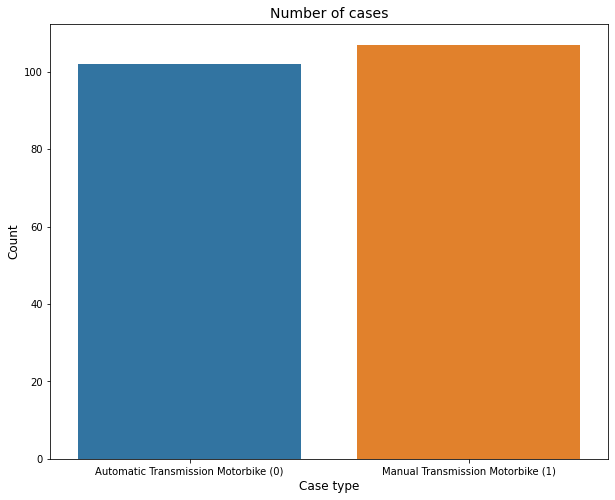

In [ ]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Automatic Transmission Motorbike (0)', 'Manual Transmission Motorbike (1)'])
plt.show()

Sử dụng thư viện ImageDataGenerator của Keras để lấy dữ liệu và phân loại
+ Rotation range = 90 degree
+ Rescale = 1./255 (từ [0-255] về [0,1])
+ Resize ảnh với kích thước width 256 height 256

Sử dụng thư viện ImageDataGenerator để gán nhãn và lấy ảnh từ directory

In [ ]:
data_gen_args = dict(rotation_range=90,
                     #width_shift_range=[-200,-200],
                     #height_shift_range=[-200,200],
                     #horizontal_flip=True,
                    #vertical_flip=True,
                     rescale=1./255
                     )
image_data_gen = ImageDataGenerator(**data_gen_args)

image_data = image_data_gen.flow_from_directory(
    directory=data_dir,
    target_size=(256, 256),
    color_mode="rgb",
    classes=['AutomaticTransmissionMotorcycle','ManualTransmissionMotorcycle'],
    class_mode="binary",
    shuffle=True,
)   

Found 209 images belonging to 2 classes.


Show Image đã được tiền xử lý dữ liệu

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


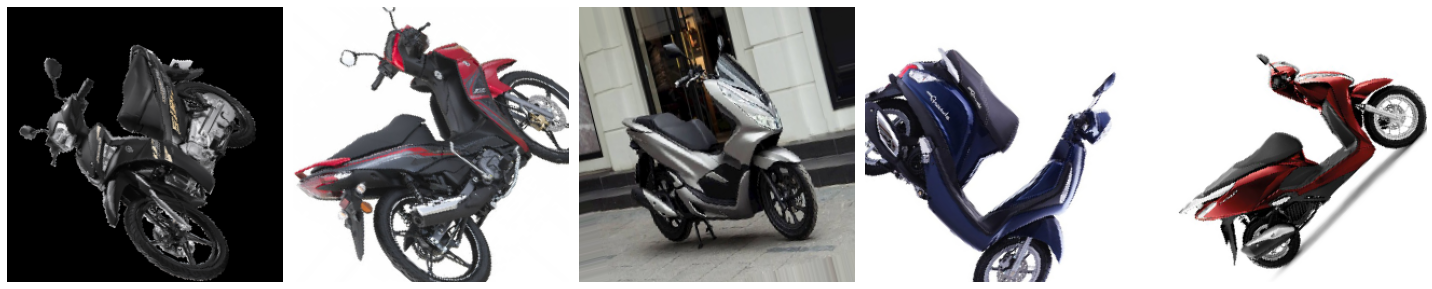

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
sample_training, labels = next(image_data)
imgplot = plotImages(sample_training[:5])

Split dữ liệu thành 2 phần 8/2:train/test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(sample_training, labels, test_size = 0.2, random_state = 1)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# fit model
train_it = []
test_it = []
n_train = len(x_train)
n_test = len(x_test)
history = model.fit_generator(image_data_gen.flow(x_train,y_train, batch_size=32), steps_per_epoch=n_train,
	validation_data=image_data_gen.flow(x_test,y_test, batch_size=32), 
	validation_steps=n_test, 
	epochs=20)

Epoch 1/20
25/25 [==============================] - 46s 2s/step - loss: 0.6898 - accuracy: 0.5904 - val_loss: 0.6878 - val_accuracy: 0.5714
Epoch 2/20
25/25 [==============================] - 42s 2s/step - loss: 0.6762 - accuracy: 0.6000 - val_loss: 0.6890 - val_accuracy: 0.5714
Epoch 3/20
25/25 [==============================] - 42s 2s/step - loss: 0.6728 - accuracy: 0.6000 - val_loss: 0.6861 - val_accuracy: 0.5714
Epoch 4/20
25/25 [==============================] - 42s 2s/step - loss: 0.6725 - accuracy: 0.6000 - val_loss: 0.6867 - val_accuracy: 0.5714
Epoch 5/20
25/25 [==============================] - 42s 2s/step - loss: 0.6723 - accuracy: 0.6000 - val_loss: 0.6864 - val_accuracy: 0.5714
Epoch 6/20
25/25 [==============================] - 42s 2s/step - loss: 0.6722 - accuracy: 0.6000 - val_loss: 0.6866 - val_accuracy: 0.5714
Epoch 7/20
25/25 [==============================] - 43s 2s/step - loss: 0.6721 - accuracy: 0.6000 - val_loss: 0.6855 - val_accuracy: 0.5714
Epoch 8/20
25/25 [==

In [ ]:
# evaluate model
_, acc = model.evaluate_generator(image_data_gen.flow(x_test,y_test,batch_size=32), steps=n_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 57.143


Kết luận:\
Sau khi train model với số lượng epochs là 20, tuy nhiên thì có thể do data nên accuaracy train vẫn không được tốt hơn những lần đầu tiên train nên gradient descent trong Model VGG không được phát huy tác dụng.\

Bộ dữ liệu cần được cập nhật thêm để có thể phát huy hết được model.\


Kết quả:\
Độ chính xác chỉ đạt được khoảng 57%.

Nhận xét:
> Do bộ dữ liệu còn ít và thiếu (dữ liệu chưa đa dạng) nên chưa thể đạt được kết quả cao.

> Còn hạn chế khi dữ liệu ảnh chỉ bao gồm 1 chiếc xe và nền trơn. Hạn chế khi dữ liệu đầu vào để nhận diện quá ít.

> Có thể sử dụng các mô hình khác để training thay vì dùng Keras khi dữ liệu quá ít.
